## Table of Contents

1. [Business Problem](#Business-Problem)
2. [Load Packages](#Load-Packages)
3. [Load Data](#Load-Data)
4. [Check Columns and Rows](#Check-Columns-and-Rows)
5. [Establish Performance Benchmark](#Establish-Performance-Benchmark)
6. [Data Cleaning Description](#Data-Cleaning-Description)
7. [Checking Ratio Of Null Values Per Column](#Checking-Ratio-Of-Null-Values-Per-Column)
8. [Create Function to Drop Columns](#Create-Function-to-Drop-Columns)
9. [Impute NA's Function](#Impute-NAs-Function)
10. [Merging Other Data](#Merging-Other-Data)
11. [Feature Engineering](#Feature-Engineering)
12. [Train Model And Create Cross Validation](#Train-Model-And-Create-Cross-Validation)
13. [Create Cross Validation](#Create-Cross-Validation)
14. [Model Explanation](#Model-Explanation)
15. [Evaluate Final Model](#Evaluate-Final-Model)
16. [Final Predictions](#Final-Predictions)
17. [Result Section](#Result-Section)

## Business Problem

## Load Packages

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import xgboost as xgb
import catboost as cb
from catboost import CatBoostRegressor  
from catboost import CatBoostClassifier  
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Load Data

In [37]:
train_df = pd.read_csv("C:/Users/Sam/Documents/CapStone/application_train.csv")
test_df = pd.read_csv("C:/Users/Sam/Documents/CapStone/application_test.csv")
previous_application = pd.read_csv("C:/Users/Sam/Documents/CapStone/previous_application.csv")
POS_CASH_balance = pd.read_csv("C:/Users/Sam/Documents/CapStone/POS_CASH_balance.csv")
# credit = pd.read_csv("C:/Users/Sam/Documents/CapStone/credit_card_balance.csv")
bureau = pd.read_csv("C:/Users/Sam/Documents/CapStone/bureau.csv")
# bureau_balance = pd.read_csv("C:/Users/Sam/Documents/CapStone/bureau_balance.csv")
# installments_payments = pd.read_csv("C:/Users/Sam/Documents/CapStone/installments_payments.csv")
# installments = pd.read_csv("C:/Users/Sam/Documents/CapStone/installments.csv")

## Check Columns and Rows

In [38]:
train_df.shape ## Checking data shape

(307511, 122)

In [39]:
train_df.columns ## Checking column types

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [40]:
test_df.shape ## Checking the test data frame shape

(48744, 121)

## Establish Performance Benchmark

In [41]:
class_counts = train_df['TARGET'].value_counts()
# Determine the majority class and its proportion in the dataset
majority_class_proportion = class_counts.max() / train_df.shape[0] * 100
print(f"Majority Class Performance Benchmark: {majority_class_proportion}%")

Majority Class Performance Benchmark: 91.92711805431351%


## Data Cleaning Description 

## Checking Ratio Of Null Values Per Column

In [42]:
values =train_df.isna().sum() / len(train_df)## Checking for the percent of missing values in each column
values.sort_values(ascending=False)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
                              ...   
NAME_HOUSING_TYPE           0.000000
NAME_FAMILY_STATUS          0.000000
NAME_EDUCATION_TYPE         0.000000
NAME_INCOME_TYPE            0.000000
SK_ID_CURR                  0.000000
Length: 122, dtype: float64

## Create Function to Drop Columns

In [43]:
def drop_columns(df, threshold=.5,exempt_columns=['TARGET']): ## Seting threshold 
    missing = df.isna().sum() / len(df)
    columns_to_drop = missing[values > threshold].index.tolist()
#     existing = [col for col in columns_to_drop if col in df.columns]
    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned  

In [44]:
train_df = drop_columns(train_df) 
test_df = drop_columns(test_df)

## Impute NA's Function 

In [45]:
def impute(df):
    for column in df.columns:
        if df[column].dtype == 'O': 
            mode_value = df[column].mode().iloc[0]
            df[column] = df[column].fillna(mode_value)  ## Impute the mode value for object columns
        else:
            median_value = df[column].median()
            df[column] = df[column].fillna(median_value) ## Impute the median value for int or num columns
    return df

In [46]:
train_df.head() ## Checking to see how this effected the data frame

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Impute NA values 

In [47]:
train_df = impute(train_df)
test_df = impute(test_df)  ## Calling the impute function

## Merging Other Data 

In [48]:
## Merging the application data
prev_app_agg = previous_application.groupby('SK_ID_CURR').agg({'AMT_APPLICATION': ['mean'],
                                                               'AMT_CREDIT': ['mean'],
                                                               'DAYS_DECISION': ['mean'],
                                                               'CNT_PAYMENT': ['mean']})
prev_app_agg.columns = ['PREVAPP_' + ('_'.join(col).upper()) for col in prev_app_agg.columns.values]

application_train = train_df.merge(prev_app_agg, on='SK_ID_CURR', how='left')
application_test = test_df.merge(prev_app_agg, on='SK_ID_CURR', how='left')

In [49]:
## Merging Cash 
POS_CASH_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg({'MONTHS_BALANCE': ['max'],
                                                           'CNT_INSTALMENT': ['mean'],
                                                           'SK_DPD': ['max']})
POS_CASH_agg.columns = ['POSCASH_' + ('_'.join(col).upper()) for col in POS_CASH_agg.columns.values]

application_train = application_train.merge(POS_CASH_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(POS_CASH_agg, on='SK_ID_CURR', how='left')

In [50]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({'DAYS_CREDIT': ['mean', 'min', 'max'],
                                               'CREDIT_DAY_OVERDUE': ['max'],
                                               'DAYS_CREDIT_ENDDATE': ['mean'],
                                               'DAYS_CREDIT_UPDATE': ['mean']})
# Flattening the multi-level columns
bureau_agg.columns = ['BUREAU_' + ('_'.join(col).upper()) for col in bureau_agg.columns.values]

# Merging aggregated bureau data with main application data
application_train = application_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [51]:
app_train = impute(application_train)
app_test = impute(application_test)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREVAPP_CNT_PAYMENT_MEAN,POSCASH_MONTHS_BALANCE_MAX,POSCASH_CNT_INSTALMENT_MEAN,POSCASH_SK_DPD_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MEAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,24.000000,-1.0,24.000000,0.0,-874.000000,-1437.0,-103.0,0.0,-349.000000,-499.875000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,10.000000,-18.0,10.107143,0.0,-1400.750000,-2586.0,-606.0,0.0,-544.500000,-816.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,4.000000,-24.0,3.750000,0.0,-867.000000,-1326.0,-408.0,0.0,-488.500000,-532.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,23.000000,-1.0,12.000000,0.0,-1050.571429,-1827.0,-300.0,0.0,-135.577778,-481.833333
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,20.666667,-1.0,15.333333,0.0,-1149.000000,-1149.0,-1149.0,0.0,-783.000000,-783.000000


## Feature Enginering

In [52]:
## Adding Division and Subtraction Based Features
application_train['NEW_EXT_SOURCE_3_DIVIDE'] = application_train['EXT_SOURCE_3'] / (application_train['AMT_CREDIT'] + 0.01) # Avoid division by zero
application_test['NEW_EXT_SOURCE_3_DIVIDE'] = application_test['EXT_SOURCE_3'] / (application_test['AMT_CREDIT'] + 0.01)

In [53]:
## Adding in Yearly Interest Rate Calculations 
app_train['YEARLY_INTEREST_RATE'] = (app_train['AMT_ANNUITY'] * 12) / app_train['AMT_CREDIT']
app_test['YEARLY_INTEREST_RATE'] = (app_test['AMT_ANNUITY'] * 12) / app_test['AMT_CREDIT']

In [54]:
## Adding in Ratio's
app_train['INCOME_TO_ANNUITY_RATIO'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_ANNUITY']
app_train['INCOME_TO_CREDIT_RATIO'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_CREDIT']

app_test['INCOME_TO_ANNUITY_RATIO'] = app_test['AMT_INCOME_TOTAL'] / app_test['AMT_ANNUITY']
app_test['INCOME_TO_CREDIT_RATIO'] = app_test['AMT_INCOME_TOTAL'] / app_test['AMT_CREDIT']

## Create Cross Validation 

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) # initialize K fold

In [56]:
X = app_train
y = X.pop('TARGET')

In [57]:
cv_results = [] ## Set up empty data frame
cv_auc_scores = []
cv_accuracy_scores = []

In [58]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] ## Create for loop for the folds
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Model Explanation 

In [59]:
def get_categorical_features(df): ## Creating a function to handle categorical features and then pass them on to the cat features in CatBoost
    cat_features = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    return cat_features 

cat_features = get_categorical_features(app_train)


model = cb.CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',  
    eval_metric='AUC',       
    custom_metric=['AUC','Accuracy'],
    random_seed=42,
    verbose=200
)

In [60]:
model.fit(
    X_train, y_train,
    cat_features=cat_features, 
    eval_set=(X_test, y_test) ## Run and test the model
)

0:	test: 0.6436110	best: 0.6436110 (0)	total: 582ms	remaining: 4m 50s
200:	test: 0.7670646	best: 0.7670646 (200)	total: 1m 44s	remaining: 2m 35s
400:	test: 0.7700787	best: 0.7701014 (398)	total: 3m 43s	remaining: 55.2s
499:	test: 0.7704487	best: 0.7704766 (497)	total: 4m 43s	remaining: 0us

bestTest = 0.7704766348
bestIteration = 497

Shrink model to first 498 iterations.


## Evaluate Final Model 

In [61]:
best_iteration = model.get_best_iteration()
eval_results = model.get_evals_result()
try:
    # Try the expected key for a single validation set
    auc = eval_results['validation']['AUC'][best_iteration]
except KeyError:
    # Log an error message and continue with a default value or alternative action
    print("KeyError encountered. Adjust the key based on your eval_results structure.")
    auc = None  # You might choose to set a default value or take other actions
    
# Calculate accuracy only if auc could be retrieved
if auc is not None:
    accuracy = model.score(X_test, y_test)
    # Append metrics to lists
    cv_auc_scores.append(auc)
    cv_accuracy_scores.append(accuracy)

    
    print(f"Fold AUC: {auc}, Fold Accuracy: {accuracy}")
else:
    # Handle the case where AUC couldn't be determined
    print("AUC could not be determined for this fold due to KeyError.")

if cv_auc_scores and cv_accuracy_scores:  # Ensure the lists aren't empty
    # Calculate and print the average AUC and accuracy across all folds
    average_auc = np.mean(cv_auc_scores)
    average_accuracy = np.mean(cv_accuracy_scores)
    print(f"Average AUC across folds: {average_auc}")
    print(f"Average Accuracy across folds: {average_accuracy}")
else:
    print("No AUC or accuracy scores were collected.")

Fold AUC: 0.7704766348174066, Fold Accuracy: 0.9198074859354167
Average AUC across folds: 0.7704766348174066
Average Accuracy across folds: 0.9198074859354167


## Final Predictions

In [62]:
pred = model.predict(application_test) ## Creating Predictions

In [63]:
result = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'TARGET': pred
})

In [64]:
file_path = "C:/Users/Sam/Documents/GitHub/2024_03_01_Home_Credit_Model/2024_03_01_Home_Credit_Model/2024_03_01_Home_Credit_Model/submision.csv"
result.to_csv(file_path, index = False)

## Feature Rank 

In [65]:
feature_importances = model.get_feature_importance()

# Create a DataFrame to display them
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importances_df.head(20))

                            Feature  Importance
39                     EXT_SOURCE_2   14.026706
40                     EXT_SOURCE_3   11.365087
94             YEARLY_INTEREST_RATE    7.721873
16                       DAYS_BIRTH    4.234756
9                   AMT_GOODS_PRICE    3.123313
2                       CODE_GENDER    2.665237
83         PREVAPP_CNT_PAYMENT_MEAN    2.568683
85      POSCASH_CNT_INSTALMENT_MEAN    2.551120
17                    DAYS_EMPLOYED    2.523310
93          NEW_EXT_SOURCE_3_DIVIDE    2.486848
12              NAME_EDUCATION_TYPE    2.333265
82       PREVAPP_DAYS_DECISION_MEAN    2.260215
89           BUREAU_DAYS_CREDIT_MAX    2.154021
91  BUREAU_DAYS_CREDIT_ENDDATE_MEAN    2.047532
84       POSCASH_MONTHS_BALANCE_MAX    1.967835
86               POSCASH_SK_DPD_MAX    1.935025
8                       AMT_ANNUITY    1.776879
7                        AMT_CREDIT    1.608603
80     PREVAPP_AMT_APPLICATION_MEAN    1.573362
19                  DAYS_ID_PUBLISH    1

## Vizualize the Feature Rank 

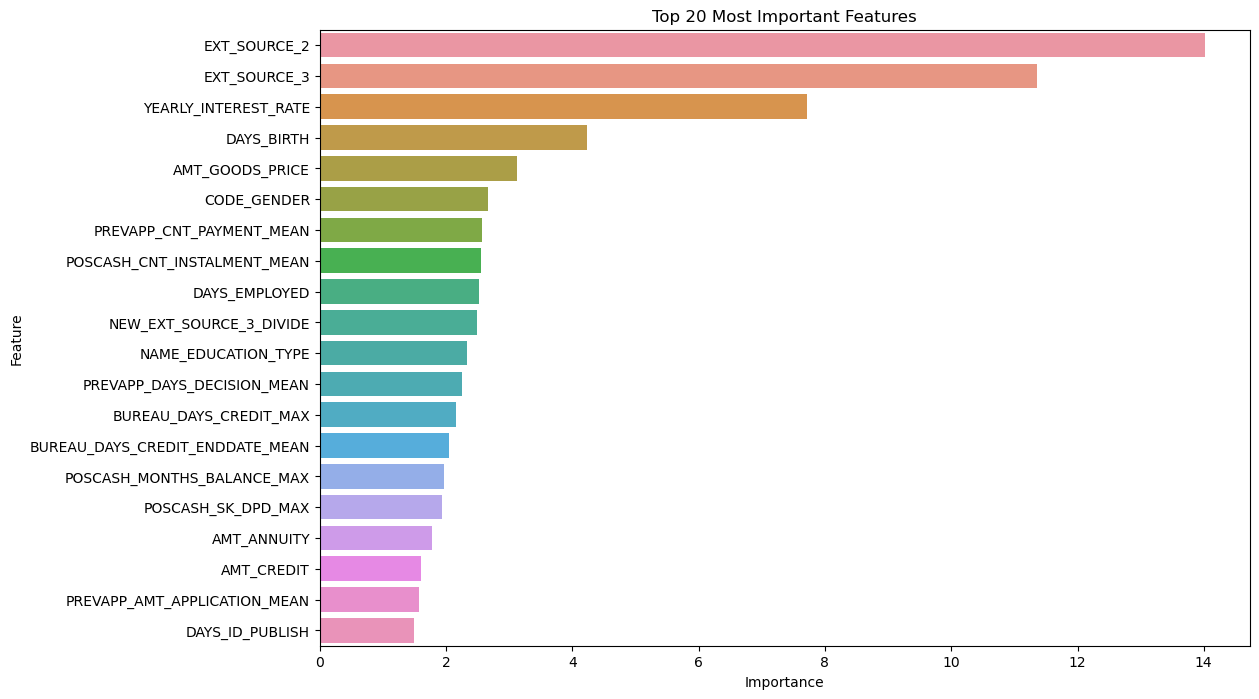

In [66]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importances_df.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

## Result Section 